In [1]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from functions import utils
import json
import warnings
warnings.filterwarnings("ignore")

In [2]:
from dotenv import load_dotenv
load_dotenv()
HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")
os.environ["HOPSWORKS_API_KEY"] = HOPSWORKS_API_KEY

In [3]:
CITY = "dublin"
STATION = "HEUSTON BRIDGE (NORTH)"

STATION = STATION.replace(" ", "_")

In [4]:
project = hopsworks.login()
fs = project.get_feature_store() 
# secrets = utils.secrets_api(project.name)

CITY = "dublin"
# latitude =
# longitude =

2025-01-21 11:12:00,194 INFO: Initializing external client
2025-01-21 11:12:00,197 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-21 11:12:01,994 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1207494


## Creating the feature view

In [5]:
# Retrieve feature groups
bike_fg = fs.get_feature_group(
    name='bike_data',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather_data',
    version=1,
)

In [6]:
selected_features = bike_fg.select(["num_bikes_available", "station"]).join(weather_fg.select_all(), on=['datetime'])

# selected_features.show(1056438)
selected_features.show(10)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.19s) 


,num_bikes_available,station,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city
0,9.0,HEUSTON_BRIDGE_(NORTH),2023-08-07 07:00:00+00:00,12.589500,10.889786,0.0,0.0,12.538134,55149.910156,0.1,dublin
1,5.0,HEUSTON_BRIDGE_(NORTH),2023-08-07 13:00:00+00:00,16.039499,14.021429,0.0,0.0,15.629971,55149.910156,0.1,dublin
2,3.0,HEUSTON_BRIDGE_(NORTH),2023-08-08 09:00:00+00:00,15.889501,15.685719,0.0,0.0,5.634891,54933.734375,0.1,dublin
3,3.0,HEUSTON_BRIDGE_(NORTH),2023-08-08 15:00:00+00:00,17.789499,17.170294,0.0,0.0,7.289445,54933.734375,0.1,dublin
4,40.0,HEUSTON_BRIDGE_(NORTH),2023-08-08 21:00:00+00:00,16.189499,16.359585,0.0,0.0,4.072935,54933.734375,0.1,dublin
5,0.0,HEUSTON_BRIDGE_(NORTH),2023-08-09 13:00:00+00:00,22.289499,23.308016,0.0,0.0,11.885453,54714.667969,0.0,dublin
6,24.0,HEUSTON_BRIDGE_(NORTH),2023-08-11 18:00:00+00:00,18.489500,15.696390,0.0,0.0,24.954519,54268.824219,0.4,dublin
7,32.0,HEUSTON_BRIDGE_(NORTH),2023-08-11 22:00:00+00:00,16.239500,13.714560,0.0,0.0,24.400459,54268.824219,0.4,dublin
8,33.0,HEUSTON_BRIDGE_(NORTH),2023-08-12 19:00:00+00:00,17.589499,15.664591,0.0,0.0,18.775303,54042.503906,6.3,dublin
9,37.0,HEUSTON_BRIDGE_(NORTH),2023-08-12 20:00:00+00:00,16.539499,14.640366,0.0,0.0,18.374111,54042.503906,6.3,dublin


In [7]:
feature_view = fs.get_or_create_feature_view(
    name='bike_weather_fw',
    description="weather features with bike availability as the target",
    version=1,
    labels=['num_bikes_available'],
    query=selected_features,    
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1207494/fs/1195126/fv/bike_weather_fw/version/1


In [8]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_size=0.2,
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.03s) 


In [9]:
# Remove rows with NaN/NaT values from X_train and X_test
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)

# Save for later
X_train_raw = X_train.copy()
X_test_raw = X_test.copy()

In [10]:
# Adjust y_train and y_test to match the cleaned X_train and X_test
y_train = y_train.loc[X_train_raw.index]
y_test = y_test.loc[X_test_raw.index]

# Ensure the datetime column is in datetime format
X_train['datetime'] = pd.to_datetime(X_train_raw['datetime'], errors='ignore')
X_test['datetime'] = pd.to_datetime(X_test_raw['datetime'], errors='ignore')

# Extract 'month' and 'weekday' from datetime
X_train['month'] = X_train['datetime'].dt.month
X_train['weekday'] = X_train['datetime'].dt.weekday  # 0=Monday, 6=Sunday
X_train['hour'] = X_train['datetime'].dt.hour
X_train = X_train.drop(columns=['datetime', "city", "station"])

X_test['month'] = X_test['datetime'].dt.month
X_test['weekday'] = X_test['datetime'].dt.weekday
X_test['hour'] = X_test['datetime'].dt.hour
X_test = X_test.drop(columns=['datetime', "city", "station"])

In [11]:
X_train

,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,month,weekday,hour
0,12.589500,10.889786,0.0,0.0,12.538134,55149.910156,0.1,8,0,7
1,16.039499,14.021429,0.0,0.0,15.629971,55149.910156,0.1,8,0,13
2,15.889501,15.685719,0.0,0.0,5.634891,54933.734375,0.1,8,1,9
3,17.789499,17.170294,0.0,0.0,7.289445,54933.734375,0.1,8,1,15
4,16.189499,16.359585,0.0,0.0,4.072935,54933.734375,0.1,8,1,21
...,...,...,...,...,...,...,...,...,...,...
9549,2.239500,-3.299663,0.0,0.0,24.890165,27908.451172,0.5,1,0,1
9550,3.289500,-1.667569,0.1,0.0,21.307774,27908.451172,0.5,1,0,13
9551,3.089500,-1.658721,0.0,0.0,19.353138,27908.451172,0.5,1,0,14
9552,-0.010500,-6.014175,0.0,0.0,24.056108,27908.451172,0.5,1,0,20


In [12]:
y_test

,num_bikes_available
10,3.0
11,1.0
17,9.0
20,31.0
21,36.0
...,...
9501,24.0
9507,27.0
9527,38.0
9530,28.0


## Training the model!

In [13]:
# Creating two instances of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [14]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 13.424659
R squared: 0.9224353293970344


In [15]:
df_station = y_test.copy()
df_station['predicted_num_bikes_available'] = y_pred

In [16]:
df_station

,num_bikes_available,predicted_num_bikes_available
10,3.0,0.982766
11,1.0,1.167330
17,9.0,11.090822
20,31.0,32.546394
21,36.0,36.529850
...,...,...
9501,24.0,28.981113
9507,27.0,26.871210
9527,38.0,35.947357
9530,28.0,17.322458


In [17]:
X_test_raw

,station,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city
10,HEUSTON_BRIDGE_(NORTH),2023-08-14 11:00:00+00:00,17.289499,16.910557,0.0,0.0,7.386582,53584.136719,0.9,dublin
11,HEUSTON_BRIDGE_(NORTH),2023-08-14 12:00:00+00:00,18.039499,17.041937,0.2,0.0,11.183201,53584.136719,0.9,dublin
17,HEUSTON_BRIDGE_(NORTH),2023-08-17 15:00:00+00:00,21.789499,20.117126,0.0,0.0,21.470612,52885.363281,0.7,dublin
20,HEUSTON_BRIDGE_(NORTH),2023-08-20 19:00:00+00:00,18.389500,16.434912,0.0,0.0,19.665359,52177.695312,0.0,dublin
21,HEUSTON_BRIDGE_(NORTH),2023-08-22 00:00:00+00:00,16.439499,14.591360,0.0,0.0,22.065973,51703.332031,0.6,dublin
...,...,...,...,...,...,...,...,...,...,...
9501,HEUSTON_BRIDGE_(NORTH),2024-12-06 16:00:00+00:00,10.739500,4.329172,0.1,0.0,40.885368,27787.359375,3.3,dublin
9507,HEUSTON_BRIDGE_(NORTH),2024-12-09 19:00:00+00:00,6.989500,3.511133,0.0,0.0,13.089354,27507.447266,0.3,dublin
9527,HEUSTON_BRIDGE_(NORTH),2024-12-22 13:00:00+00:00,6.739500,-0.400204,0.0,0.0,34.863358,27011.623047,0.2,dublin
9530,HEUSTON_BRIDGE_(NORTH),2024-12-24 12:00:00+00:00,11.939500,9.456330,0.0,0.0,19.761507,27044.955078,0.1,dublin


In [18]:
df_station['datetime'] = X_test_raw['datetime']
df_station_1 = df_station.sort_values(by=["datetime"])
df_station_1.head(5)

,num_bikes_available,predicted_num_bikes_available,datetime
8432,7.0,1.363538,2023-08-07 16:00:00+00:00
5426,2.0,3.125463,2023-08-08 02:00:00+00:00
4171,2.0,2.370079,2023-08-08 05:00:00+00:00
2398,0.0,9.337511,2023-08-08 08:00:00+00:00
1822,38.0,37.008179,2023-08-09 05:00:00+00:00


In [19]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "bike_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

In [20]:
# THIS DOES NOT WORK BECAUSE WE DON'T USE A SPECIFIC TIME FOR TESTING.
# 
# Instead, we use random data in order to get a better spread in the evaluation, 
# as the model might perform different during different times of year

"""
file_path = images_dir + "/bikes_hindcast"
plt_1 = utils.plot_bike_availability_forecast(CITY, STATION_1, df_station_1, file_path + "_1.png", hindcast=True) 
plt_2 = utils.plot_bike_availability_forecast(CITY, STATION_2, df_station_2, file_path + "_2.png", hindcast=True)
plt_1.show()
plt_2.show()
"""

'\nfile_path = images_dir + "/bikes_hindcast"\nplt_1 = utils.plot_bike_availability_forecast(CITY, STATION_1, df_station_1, file_path + "_1.png", hindcast=True) \nplt_2 = utils.plot_bike_availability_forecast(CITY, STATION_2, df_station_2, file_path + "_2.png", hindcast=True)\nplt_1.show()\nplt_2.show()\n'

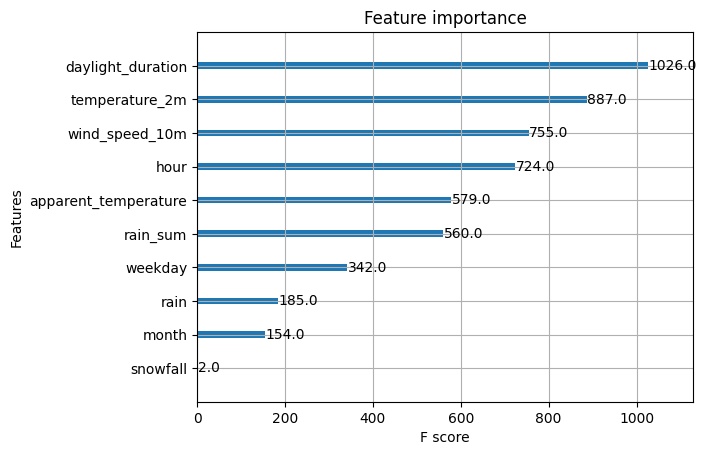

In [21]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

## Model Schema

In [22]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [23]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [24]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [25]:
mr = project.get_model_registry()

bike_availability_model = mr.python.create_model(
    name="bike_availability_xgboost_model", 
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Bike availability prediction for " + STATION + " in " + CITY + " using XGBoost",
)

bike_availability_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/589448 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/26575 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/138 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/973 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1207494/models/bike_availability_xgboost_model/5


Model(name: 'bike_availability_xgboost_model', version: 5)